# Chapter 3: Classification
The most common machine learning tasks are regression (predicating values) and classification (predicting classes). This notebook will be used to focus on classification, particularly with the MNIST dataset.

## What is MNIST?
*MNIST* is a popular dataset consisting of 70,000 small handwritten digits. So popular, it's an included dataset for Scikit-Learn. 

Lets fetch the MNIST dataset:

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

You can see all of the different datapoints of consideration for MNIST, but we'll look at 2 in particular: `data` and `target`.

In [2]:
import numpy as np
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8) # convert the string labels into integer labels
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


As our `y` variable represents our label, there's `70000` different objects that need to be labelled. As for our `X`, there is indeed `70000` different objects to be labelled, but alongside that, each data point has a 28 by 28 array representing the intensity of the pixel. Lets plot one of these data points to understand further:

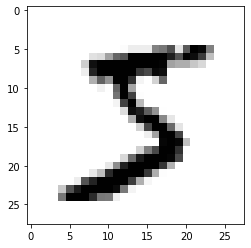

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.show()

In [4]:
y[0]

5

It's clear to see that `data` and `target` are directly linked.

Before we continue, we should split out dataset into test and train as not to expose the testing/data exploration phase to the test and training phases.

In [5]:
# use the first 60000 images for training and the last 10000 images for testing
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Performance Measures
There are a variety of different ways to measure how well a model is performing. A common way is by using *accuracy*, however it has it's pitfalls. Here, we'll explore other methods in measuring performance.

### Confustion Matrix
For each row of a confusion matrix, it represents an *actual class*, while each column represents a *predicted class*. They're known as **true positives, true negatives, false positives,** and **false negatives**:
* True positive - the number of instances in which the model said an image was "positive" (in a class) and it was correct
* True negatives - the number of instances in which the model said an image was "negative" (NOT in a class) and it was correct
* False positives - the number of instances in which the model said an image was "positive" and it was incorrect
* False negatives - the number of instances in which the model said an image was "negative" and it was incorrect

The perfect classifier would only have true positives and true negatives.

### Precision
The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. One to consider may be the accuracy of the positive predictions, known as **precision**. This is calculated with $$\frac{TP}{TP+FP}$$ where $TP$ is *true positive* and $FP$ is *false positive*.

### Recall
Typically, precision on it's own is not very useful, so it is often used with **recall**, sometimes referred to as the *sensitivity* or the *true positive rate*. This is calculated with $$\frac{TP}{TP+FN}$$ where $FN$ is *false negative*.

### F Score
Another metric to consider the **F score**, which is the *harmonic mean* of precision and recall. This is nice because it weighs the model's incorrect classifications more heavily than just precision and recall alone. To calculate this with $$\frac{TP}{TP+\frac{FN+FP}{2}}$$.

All of these metrics can be found in the `sklearn.metrics` module using `confusion_matrix`, `precision_score`, `recall_score`, and `f1_score`.

It should be noted that F Score typically works better with similar precision and recall scores, and also that typically when trying to improve one metric, you'll hurt the other. This is known as the *Precision/Recall Tradeoff*.


***With all of this being said,*** let's try building a classifier for the number 5 from the MNIST dataset:

In [6]:
 # grabs all the instanes of 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

From here, we'll use the `SGDClassifier` (**S**tochastic **G**radient **D**escent) to perform our classification:

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) # this classifier relies on randomness during training, hence the stochastic
sgd_clf.predict([some_digit])

array([ True])

Awesome! So the classifier accurately predicted that the digit we selected earlier was indeed a 5! Lets check with all of the other metrics we defined earlier:

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Our classifier did well on our own digit that we selected at the beginning, and according to the confusion matrix it was able to correctly classify $\frac{57422}{60000}$, which is about 96%! Not too shabby! Now lets try looking at the precision and recall scores:

In [9]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [10]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Now we start to see the flaws more clearly. It seems that our model is able to somewhat accurate classify 5's (precision score), however it's overcompensating by classifying more false negatives to achieve this result. This is not what we want.

Now lets look at the F score:

In [11]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Tradeoff
Given this, lets try to look at how the `SGDClassifier` is working under the hood. While we can't change our deciison threshold directly, we can look at the decision scores instead of the prediction itself to see how the classification is actually working:

In [12]:
y_scores = sgd_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Using a threshold of 1 is the same as simply using the `predict` function. Lets try raising our threshold:

In [13]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

We see now that the classifier incorrectly classified our true ground number, resulting in a false negative. This means that raising the threshold results in a decrease in our recall.

To decide what kind of threshold to use, we start by getting the scores of all instances in the training set using the `cross_val_predict()` method, but this time specify that you want it to return the decision scores rather than the predictions. From there, we can compute the precision and recall scores for all possible thresholds using the `precision_recall_curve()` function. And then finally, we can plot how they compare using `matplotlib`:

In [14]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [15]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])

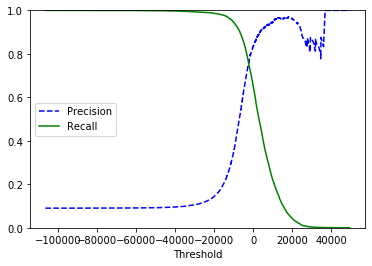

In [16]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

We can see where the precision and recall scores intersect based on the thresholds, we simply pick that intersection point. Another way to do this is to simply plot the precision and recall scores together and see where the drop off point is most evident.

## The ROC Curve
The **reciever operating characteristic** is another common tool used with binary classifiers. This works very similarly to plotting the precision/recall curve as we did before, however instead we look at the *true positive rate* (recall) vs. the *false positive rate* (FPR), where the FPR is the ratio of negative instances that are incorrectly classified as positive. Another way to think of the ROC Curve is that it looks at *sensitivity* vs *specificity*.

To do this, you just import the `roc_curve` method from `sklearn.metrics`.

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Now that we have the fpr and tpr, we can plot them using `matplotlib``

In [20]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

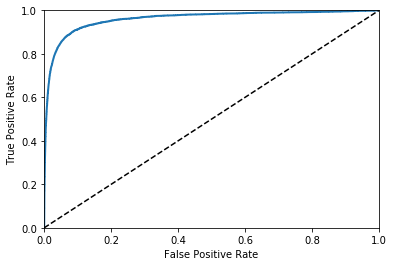

In [21]:
plot_roc_curve(fpr, tpr)
plt.show()

This is further evidence that there's a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces.

Now lets try comparing classifiers, using the area under the curve. This can be done by using the ``roc_auc_score()`` function. Lets use the `RandomForestClassifier` and compare:

C:\Users\Nicole\miniconda3\envs\oreilly_ml\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Nicole\miniconda3\envs\oreilly_ml\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Nicole\miniconda3\envs\oreilly_ml\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


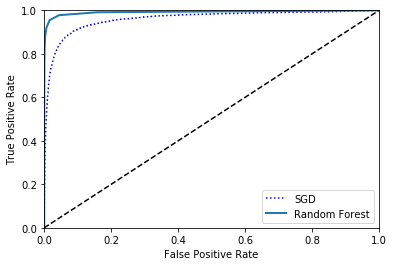

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

# to plot a ROC curve you need scores not probabilities. to do this use the positive class's probability as the score
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

It's clear that based off of this graph, the `RandomForestClassifier` is working better than the `SGDClassifier`, and this is even more evident based on their precision and recall scores:

In [23]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

C:\Users\Nicole\miniconda3\envs\oreilly_ml\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Nicole\miniconda3\envs\oreilly_ml\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Nicole\miniconda3\envs\oreilly_ml\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.986046511627907

In [26]:
recall_score(y_train_5, y_train_pred_forest)

0.8212506917542889

## Multiclass Classification
So far we've only tackled binary classification, in which we're trying to put an object into one of two classes. We can also do a **Multiclass Classification** in which we'll try to classify an object into one of many classes.

Common algorithms that support multiclass classification are Random Forest classifiers or naive Bayes classifiers.